# Importing Libraries

In [1]:
# pytorch
%pip install torch==1.12.0+cu116 torchvision==0.13.0+cu116 torchaudio==0.12.0 --extra-index-url https://download.pytorch.org/whl/cu116 --quiet
# pytorch-geometric
%pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu116.html --quiet
# pytorch-geometric-temporal
%pip install torch-geometric-temporal --quiet
# pymap2d
%pip install pymap2d --quiet
# openpyxl for excel export using pandas
%pip install openpyxl --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from CMap2D import gridshow, CMap2D
import time
import pickle
import seaborn as sns
import matplotlib.image as mpimg

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2, TGCN2
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric.utils import dense_to_sparse
from torch_geometric_temporal import StaticGraphTemporalSignal

# CUDA 

In [2]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-4811939e-a19c-c041-fb03-83903851e721)


In [3]:
# GPU support
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Import data

In [4]:
shuffle=True
batch_size = 32
periods_in = 5
periods_out = 40
lst_idx_features = [0,1,2,3] # for all node features use[0,1,2,3], 1=wall, 2=coffee, 3=workbench

In [5]:
idx = np.load("../test input files/idx_sim2_100p_5_40.npy")

In [6]:
p_data = pickle.load(open("../test input files/dataset_norm_sim2_100p_5_40.p", "rb"))
dataset = p_data[0]
print(next(iter(dataset)))

mean_features = p_data[1]
std_features = p_data[2]

Data(x=[3846, 4, 5], edge_index=[2, 31510], edge_attr=[31510], y=[3846, 40])


# Data preperation

In [7]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

print("Number of train buckets: ", len(list(train_dataset)))
print("Number of test buckets: ", len(list(test_dataset)))

Number of train buckets:  5004
Number of test buckets:  1251


In [8]:
train_dataset_new = torch.utils.data.TensorDataset(torch.from_numpy(np.array(train_dataset.features)[:,:,:,:periods_in]).type(torch.FloatTensor), torch.from_numpy(np.array(train_dataset.targets)[:,:,:periods_out]).type(torch.FloatTensor))
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)
test_dataset_new = torch.utils.data.TensorDataset(torch.from_numpy(np.array(test_dataset.features)[:,:,:,:periods_in]).type(torch.FloatTensor), torch.from_numpy(np.array(test_dataset.targets)[:,:,:periods_out]).type(torch.FloatTensor))
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

# A3T-GCN Model

In [9]:
class TGCN2(torch.nn.Module):
    r"""An implementation THAT SUPPORTS BATCHES of the Temporal Graph Convolutional Gated Recurrent Cell.
    For details see this paper: `"T-GCN: A Temporal Graph ConvolutionalNetwork for
    Traffic Prediction." <https://arxiv.org/abs/1811.05320>`_
    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        batch_size (int): Size of the batch.
        improved (bool): Stronger self loops. Default is False.
        cached (bool): Caching the message weights. Default is False.
        add_self_loops (bool): Adding self-loops for smoothing. Default is True.
    """

    def __init__(self, in_channels: int, out_channels: int, 
                 batch_size: int,  # this entry is unnecessary, kept only for backward compatibility
                 improved: bool = False, cached: bool = False, 
                 add_self_loops: bool = True):
        super(TGCN2, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.cached = cached
        self.add_self_loops = add_self_loops
        self.batch_size = batch_size  # not needed
        self._create_parameters_and_layers()

    def _create_update_gate_parameters_and_layers(self):
        self.conv_z = ChebConv(in_channels=self.in_channels,  out_channels=self.out_channels, K=10, normalization="sym", agrr="add")
        self.linear_z = torch.nn.Linear(2 * self.out_channels, self.out_channels)

    def _create_reset_gate_parameters_and_layers(self):
        self.conv_r = ChebConv(in_channels=self.in_channels,  out_channels=self.out_channels, K=10, normalization="sym", agrr="add")
        self.linear_r = torch.nn.Linear(2 * self.out_channels, self.out_channels)

    def _create_candidate_state_parameters_and_layers(self):
        self.conv_h = ChebConv(in_channels=self.in_channels,  out_channels=self.out_channels, K=10, normalization="sym", agrr="add")
        self.linear_h = torch.nn.Linear(2 * self.out_channels, self.out_channels)

    def _create_parameters_and_layers(self):
        self._create_update_gate_parameters_and_layers()
        self._create_reset_gate_parameters_and_layers()
        self._create_candidate_state_parameters_and_layers()

    def _set_hidden_state(self, X, H):
        if H is None:
            # can infer batch_size from X.shape, because X is [B, N, F]
            H = torch.zeros(X.shape[0], X.shape[1], self.out_channels).to(X.device) #(b, 207, 32)
        return H

    def _calculate_update_gate(self, X, edge_index, edge_weight, H):
        Z = torch.cat([self.conv_z(X, edge_index, edge_weight), H], axis=2) # (b, 207, 64)
        Z = self.linear_z(Z) # (b, 207, 32)
        Z = torch.sigmoid(Z)

        return Z

    def _calculate_reset_gate(self, X, edge_index, edge_weight, H):
        R = torch.cat([self.conv_r(X, edge_index, edge_weight), H], axis=2) # (b, 207, 64)
        R = self.linear_r(R) # (b, 207, 32)
        R = torch.sigmoid(R)

        return R

    def _calculate_candidate_state(self, X, edge_index, edge_weight, H, R):
        H_tilde = torch.cat([self.conv_h(X, edge_index, edge_weight), H * R], axis=2) # (b, 207, 64)
        H_tilde = self.linear_h(H_tilde) # (b, 207, 32)
        H_tilde = torch.tanh(H_tilde)

        return H_tilde

    def _calculate_hidden_state(self, Z, H, H_tilde):
        H = Z * H + (1 - Z) * H_tilde   # # (b, 207, 32)
        return H

    def forward(self,X: torch.FloatTensor, edge_index: torch.LongTensor, edge_weight: torch.FloatTensor = None,
                H: torch.FloatTensor = None ) -> torch.FloatTensor:
        """
        Making a forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph. If the hidden state matrix is not present
        when the forward pass is called it is initialized with zeros.
        Arg types:
            * **X** *(PyTorch Float Tensor)* - Node features.
            * **edge_index** *(PyTorch Long Tensor)* - Graph edge indices.
            * **edge_weight** *(PyTorch Long Tensor, optional)* - Edge weight vector.
            * **H** *(PyTorch Float Tensor, optional)* - Hidden state matrix for all nodes.
        Return types:
            * **H** *(PyTorch Float Tensor)* - Hidden state matrix for all nodes.
        """
        H = self._set_hidden_state(X, H)
        Z = self._calculate_update_gate(X, edge_index, edge_weight, H)
        R = self._calculate_reset_gate(X, edge_index, edge_weight, H)
        H_tilde = self._calculate_candidate_state(X, edge_index, edge_weight, H, R)
        H = self._calculate_hidden_state(Z, H, H_tilde) # (b, 207, 32)
        return H

In [10]:
class A3TGCN2(torch.nn.Module):
    r"""An implementation THAT SUPPORTS BATCHES of the Attention Temporal Graph Convolutional Cell.
    For details see this paper: `"A3T-GCN: Attention Temporal Graph Convolutional
    Network for Traffic Forecasting." <https://arxiv.org/abs/2006.11583>`_
    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        periods (int): Number of time periods.
        improved (bool): Stronger self loops (default :obj:`False`).
        cached (bool): Caching the message weights (default :obj:`False`).
        add_self_loops (bool): Adding self-loops for smoothing (default :obj:`True`).
    """

    def __init__(
        self,
        in_channels: int, 
        out_channels: int,  
        periods: int, 
        batch_size:int, 
        improved: bool = False,
        cached: bool = False,
        add_self_loops: bool = True):
        super(A3TGCN2, self).__init__()

        self.in_channels = in_channels  # 2
        self.out_channels = out_channels # 32
        self.periods = periods # 12
        self.improved = improved
        self.cached = cached
        self.add_self_loops = add_self_loops
        self.batch_size = batch_size
        self._setup_layers()

    def _setup_layers(self):
        self._base_tgcn = TGCN2(
            in_channels=self.in_channels,
            out_channels=self.out_channels,  
            batch_size=self.batch_size,
            improved=self.improved,
            cached=self.cached, 
            add_self_loops=self.add_self_loops)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self._attention = torch.nn.Parameter(torch.empty(self.periods, device=device))
        torch.nn.init.uniform_(self._attention)

    def forward( 
        self, 
        X: torch.FloatTensor,
        edge_index: torch.LongTensor, 
        edge_weight: torch.FloatTensor = None,
        H: torch.FloatTensor = None
    ) -> torch.FloatTensor:
        """
        Making a forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph. If the hidden state matrix is not present
        when the forward pass is called it is initialized with zeros.
        Arg types:
            * **X** (PyTorch Float Tensor): Node features for T time periods.
            * **edge_index** (PyTorch Long Tensor): Graph edge indices.
            * **edge_weight** (PyTorch Long Tensor, optional)*: Edge weight vector.
            * **H** (PyTorch Float Tensor, optional): Hidden state matrix for all nodes.
        Return types:
            * **H** (PyTorch Float Tensor): Hidden state matrix for all nodes.
        """
        H_accum = 0
        probs = torch.nn.functional.softmax(self._attention, dim=0)
        for period in range(self.periods):

            H_accum = H_accum + probs[period] * self._base_tgcn( X[:, :, :, period], edge_index, edge_weight, H) #([32, 207, 32]

        return H_accum

In [11]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods_in, periods_out, batch_size, num_edges):
        super(TemporalGNN, self).__init__()
        
        # initialize learnable edge weights
        self.edge_weight = torch.nn.Parameter(torch.full((num_edges, ), 1/8))
        
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features, out_channels=256, periods=periods_in, batch_size=batch_size)
            
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(256, periods_out)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """        
        h = self.tgnn(x, edge_index, self.edge_weight.relu())
        #print(self.edge_weight.std())
        h = F.relu(h)
        h = self.linear(h)
        
        return h

In [12]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index
    static_edge_index = static_edge_index.to(DEVICE)
    break

In [13]:
model = TemporalGNN(node_features=len(lst_idx_features), periods_in=periods_in, periods_out=periods_out, batch_size=batch_size, num_edges=static_edge_index.shape[1]).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.05)
loss_fn = torch.nn.MSELoss()

# Train Model

In [14]:
t = time.time()
model.train()

for epoch in range(5):
    step = 0
    loss_list = []

    for encoder_inputs, labels in train_loader:       
        # add to GPU iteratively
        encoder_inputs, labels = encoder_inputs.to(DEVICE), labels.to(DEVICE)
        y_hat = model(encoder_inputs[:,:,lst_idx_features,:], static_edge_index)
        
        loss = loss_fn(y_hat, labels)    
        
        # accumulate gradient if not 'step % 1 == 0'
        if step % 1 == 0:
            optimizer.zero_grad()
            
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 10)        
        optimizer.step()
        
        step += 1
        loss_list.append(loss.item())
        
        if step % 100 == 0:
            print(sum(loss_list)/len(loss_list))

    
    print("Epoch {} train loss: {:.4f}".format(epoch+1, sum(loss_list)/len(loss_list)))
print("runtime of {} epochs: {:.2f}".format(epoch+1, time.time() - t))

0.4689704865217209
Epoch 1 train loss: 0.4537
0.4200870969891548
Epoch 2 train loss: 0.4191
0.41482130289077757
Epoch 3 train loss: 0.4142
0.41269305497407915
Epoch 4 train loss: 0.4118
0.4106190952658653
Epoch 5 train loss: 0.4104
runtime of 5 epochs: 457.68


### Test MSE

In [15]:
model.eval()
total_loss = []
with torch.no_grad():
    for encoder_inputs, labels in test_loader:
        # assign to GPU
        encoder_inputs, labels = encoder_inputs.to(DEVICE), labels.to(DEVICE)

        # Get model predictions
        yhat = model(encoder_inputs[:,:,lst_idx_features,:], static_edge_index)
        
        # Mean squared error
        loss = loss_fn(yhat, labels)
        total_loss.append(loss.item())
        
print("Test MSE: {:.4f}".format(sum(total_loss) / len(total_loss)))

Test MSE: 0.4115


### Denormalize

In [16]:
def denormalize(mean, std, arr):
    return np.round((arr*std)+mean, decimals=5)

### Evaluate Performance

In [17]:
thresholds = [0.01, 0.05, 0.1, 0.15, 0.25, 0.6]

model.eval()

# Store for analysis
total_loss = []
r_mse = {}
r_precision = {}
r_recall = {}
r_accuracy = {}
r_f1 = {}
r_balanced_accuracy = {}
r_f_B = {}

B = 2
F_B = "F" + str(B)

with torch.no_grad():
    for encoder_inputs, labels in test_loader:
        # assign to GPU
        encoder_inputs, labels = encoder_inputs.to(DEVICE), labels.to(DEVICE)

        # Get model predictions
        yhat = model(encoder_inputs[:,:,lst_idx_features,:], static_edge_index)
        
        # Mean squared error
        loss = loss_fn(yhat, labels)
        total_loss.append(loss.item())
        
        # detach from GPU
        yhat_detached = yhat.cpu().detach().numpy()
        labels_detached = labels.cpu().detach().numpy()
        
        # undo normalization
        yhat_detached = denormalize(mean_features[0], std_features[0], yhat_detached)
        labels_detached = denormalize(mean_features[0], std_features[0], labels_detached)
        
        for threshold in thresholds:       
            if threshold not in r_precision.keys():
                # nested dictionaries to store results
                r_mse[threshold] = {}
                r_precision[threshold] = {}
                r_recall[threshold] = {}
                r_accuracy[threshold] = {}
                r_f1[threshold] = {}
                r_balanced_accuracy[threshold] = {}
                r_f_B[threshold] = {}

            # use threshold to make predictions binary
            y_hat = np.where(yhat_detached > threshold, 1, 0)
            labels_ = np.where(labels_detached > threshold, 1, 0)

            for t in range(periods_out):
                if t not in r_precision[threshold].keys():
                    r_mse[threshold][t] = []
                    r_precision[threshold][t] = []
                    r_recall[threshold][t] = []
                    r_accuracy[threshold][t] = []
                    r_f1[threshold][t] = []
                    r_balanced_accuracy[threshold][t] = []
                    r_f_B[threshold][t] = []
                
                loss = np.mean(np.mean((y_hat[:, :, t] - labels_[:, :, t])**2, axis=1))
                r_mse[threshold][t].append(loss)
                
                # precision --> tp / (tp + fp)
                tp = len(np.where((y_hat[:, :, t] == labels_[:, :, t]) & (y_hat[:, :, t] == 1))[0])
                fp = len(np.where((y_hat[:, :, t] != labels_[:, :, t]) & (y_hat[:, :, t] == 1))[0])
                try:
                    precision = tp / (tp + fp)
                except ZeroDivisionError:
                    precision = 0
                r_precision[threshold][t].append(precision)
                
                # recall --> tp/(tp+fn)
                fn = len(np.where((y_hat[:, :, t] != labels_[:, :, t]) & (y_hat[:, :, t] == 0))[0])
                try:
                    recall = tp / (tp + fn)
                except ZeroDivisionError:
                    recall = 0
                r_recall[threshold][t].append(recall)

                # accuracy --> (tp+tn) / (tp+tn+fp+fn)
                tn = len(np.where((y_hat[:, :, t] == labels_[:, :, t]) & (y_hat[:, :, t] == 0))[0])
                try:
                    accuracy = (tp + tn) / (tp + tn + fp + fn)
                except ZeroDivisionError:
                    accucary = 0
                r_accuracy[threshold][t].append(accuracy)
                
                # balanced accuracy --> (TPR(recall) + TNR)/2
                tn = len(np.where((y_hat[:, :, t] == labels_[:, :, t]) & (y_hat[:, :, t] == 0))[0])
                n = len(np.where(labels_[:, :, t] == 0)[0])
                TNR = tn/n
                balanced_accuracy = (recall + TNR)/2
                r_balanced_accuracy[threshold][t].append(balanced_accuracy)
                
                # F1 score --> 2 * (precision*recall)/(precision + recall)
                try:
                    f1 = 2 * (precision * recall) / (precision + recall)
                    f_B = (1 + B**2) * (precision * recall) / (B**2 * precision + recall)
                except ZeroDivisionError: 
                    f1 = 0
                    f_B = 0
                r_f1[threshold][t].append(f1)
                r_f_B[threshold][t].append(f_B)

for threshold in thresholds:
    for i in range(periods_out):
        r_mse[threshold][i] = sum(r_mse[threshold][i]) / len(r_mse[threshold][i])
        r_precision[threshold][i] = sum(r_precision[threshold][i]) / len(r_precision[threshold][i])
        r_recall[threshold][i] = sum(r_recall[threshold][i]) / len(r_recall[threshold][i])
        r_accuracy[threshold][i] = sum(r_accuracy[threshold][i]) / len(r_accuracy[threshold][i])
        r_f1[threshold][i] = sum(r_f1[threshold][i]) / len(r_f1[threshold][i])
        r_balanced_accuracy[threshold][i] = sum(r_balanced_accuracy[threshold][i]) / len(r_balanced_accuracy[threshold][i])
        r_f_B[threshold][i] = sum(r_f_B[threshold][i]) / len(r_f_B[threshold][i])

### Export to excel

In [18]:
with pd.ExcelWriter("output_sim2_100p.xlsx") as writer:
    for threshold in thresholds:
        df = pd.DataFrame()
        df["MSE"] = r_mse[threshold].values()
        df["Accuracy"] = r_accuracy[threshold].values()
        df["Balanced Accuracy"] = r_balanced_accuracy[threshold].values()
        df["Recall"] = r_recall[threshold].values()
        df["Precision"] = r_precision[threshold].values()
        df[F_B] = r_f_B[threshold].values()
        df["F1"] = r_f1[threshold].values()
        df.index += 1
        
        df.to_excel(writer, sheet_name=str(threshold), index=False)

### Find optimal threshold

In [19]:
lst_best = [] # can also do average but doesn't matter since length is the always same for each threshold
for threshold in thresholds:
    lst_best.append(sum(list(r_balanced_accuracy[threshold].values())))
best_threshold = list(r_balanced_accuracy.keys())[np.argmax(lst_best)]

print("Optimal threshold is {:.2f} based on balanced accuracy".format(best_threshold))
print("")
print("Test MSE: {:.4f}".format(sum(total_loss) / len(total_loss)))
print("Test accuracy: {:.4f}".format(sum(list(r_accuracy[best_threshold].values()))/len(list(r_accuracy[best_threshold].values()))))
print("Test balanced accuracy: {:.4f}".format(sum(list(r_balanced_accuracy[best_threshold].values()))/len(list(r_balanced_accuracy[best_threshold].values()))))
print("Test precision: {:.4f}".format(sum(list(r_precision[best_threshold].values()))/len(list(r_precision[best_threshold].values()))))
print("Test recall: {:.4f}".format(sum(list(r_recall[best_threshold].values()))/len(list(r_recall[best_threshold].values()))))
print("Test F1: {:.4f}".format(sum(list(r_f1[best_threshold].values()))/len(list(r_f1[best_threshold].values()))))
print("Test ", F_B, ": {:.4f}".format(sum(list(r_f_B[best_threshold].values()))/len(list(r_f_B[best_threshold].values()))))
print("\n")

df = pd.DataFrame()
df["MSE"] = r_mse[best_threshold].values()
df["Accuracy"] = r_accuracy[best_threshold].values()
df["Balanced Accuracy"] = r_balanced_accuracy[best_threshold].values()
df["Recall"] = r_recall[best_threshold].values()
df["Precision"] = r_precision[best_threshold].values()
df[F_B] = r_f_B[best_threshold].values()
df["F1"] = r_f1[best_threshold].values()

df.index += 1

print(df.head(periods_out))

Optimal threshold is 0.10 based on balanced accuracy

Test MSE: 0.4114
Test accuracy: 0.9002
Test balanced accuracy: 0.8563
Test precision: 0.4825
Test recall: 0.8021
Test F1: 0.6023
Test  F2 : 0.7081


         MSE  Accuracy  Balanced Accuracy    Recall  Precision        F2  \
1   0.064378  0.935622           0.942965  0.952007   0.599202  0.851703   
2   0.075946  0.924054           0.918156  0.910893   0.558961  0.809011   
3   0.073922  0.926078           0.905233  0.879562   0.569117  0.793034   
4   0.074236  0.925764           0.896395  0.860227   0.569594  0.780563   
5   0.080028  0.919972           0.888845  0.850514   0.547823  0.765874   
6   0.083240  0.916760           0.882416  0.840123   0.536478  0.754687   
7   0.086823  0.913177           0.875995  0.830207   0.524002  0.743328   
8   0.088927  0.911073           0.867112  0.812977   0.517050  0.729470   
9   0.096803  0.903197           0.856048  0.797990   0.490688  0.709161   
10  0.101892  0.898108           0.85

## Store Model

In [20]:
# store best pytorch model
torch.save(model.state_dict(), "model_state_dict.pt")

## Export results to txt

In [21]:
def export_as_txt(yhat: np.ndarray, path: str = "", regression_output: bool = True, classification_output: bool = False, threshold: float = None, denorm: bool = True):
    if denorm == True:
        y_hat = denormalize(mean_features[0], std_features[0], yhat)
    else:
        y_hat = yhat
        
    for i in range(y_hat.shape[2]):
        if regression_output==True:
            np.savetxt(path + "heatmap_reg_t" + str(i+1) + ".txt", y_hat[0, :, i])
        if classification_output==True:
            y_hat = np.where(y_hat > threshold, 1, 0).astype("uint8")
            np.savetxt(path + "heatmap_class_t" + str(i + 1) + ".txt", y_hat[0, :, i])

In [22]:
export_as_txt(yhat.cpu().detach().numpy(), path="", regression_output=True, classification_output=False, denorm=True)

## Plot Heatmap

In [23]:
def back_to_occupancy_grid(F, idx, batch_nr):
    """add back the removed nodes"""
    full_F = np.insert(F[batch_nr][:,], idx[0] - np.arange(len(idx[0])), 0, axis=0)

    return full_F

In [24]:
def plot_heatmap(yhat, t):
    t -= 1
    y_hat = yhat.cpu().detach().numpy()
    y_hat = back_to_occupancy_grid(y_hat, idx, batch_nr=1)
    y_hat = np.array(np.array_split(y_hat[:,t], 100))
    y_hat = np.rot90(y_hat)
    
    ax = sns.heatmap(y_hat, linewidths=0, square=True, cmap='RdYlGn_r', zorder=2, alpha=0.6, cbar=False,vmin=0, vmax=1)
    my_image = mpimg.imread("simu2.png")
    ax.imshow(my_image, aspect=ax.get_aspect(), extent=ax.get_xlim() + ax.get_ylim(), zorder=1)

    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    plt.show()

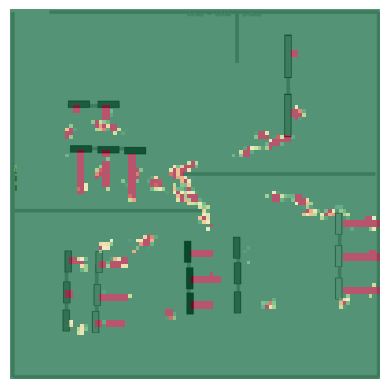

In [25]:
plot_heatmap(yhat, t=1)

## Plot Occupancy Grid


In [26]:
def reshape_output(y, t, threshold):
    t -= 1
    y = y[:, t]
    y = np.where(y>threshold, 1, 0)
    y = np.array(np.array_split(y, 100))

    return y

In [27]:
def plot_occupancy_grid(y_hat, labels, t, batch_nr, threshold):
    y_hat = y_hat.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    
    y_hat = back_to_occupancy_grid(y_hat, idx, batch_nr=batch_nr)
    labels = back_to_occupancy_grid(labels, idx, batch_nr=batch_nr)    
    
    yhat1 = reshape_output(y_hat, t=t, threshold=threshold)
    ytrue1 = reshape_output(labels, t=t, threshold=0.5)    # to get it to be binary if 1/2/3... person present --> all =1 
       
    grid1 = CMap2D()
    grid2 = CMap2D()

    fig, (ax1, ax2) = plt.subplots(1, 2)
    grid1.from_array(yhat1, origin=(0,0), resolution=1.)
    
    plt.sca(ax1)
    plt.title("Predicted Occupancy Grid")
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    
    gridshow(grid1.occupancy())

    grid2.from_array(ytrue1, origin=(0,0), resolution=1.)
    plt.sca(ax2)
    plt.title("Actual Occupancy Grid")
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    gridshow(grid2.occupancy())

    plt.savefig("sim4_50p_th=0.1.png")

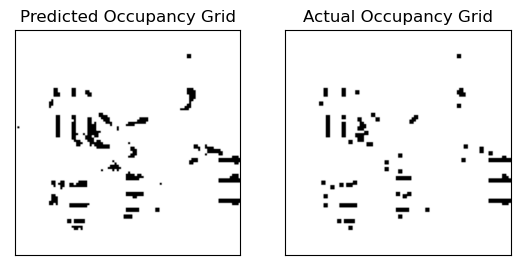

In [28]:
plot_occupancy_grid(yhat, labels, t=1, batch_nr=2, threshold=0.1)

### Figure - threshold vs time

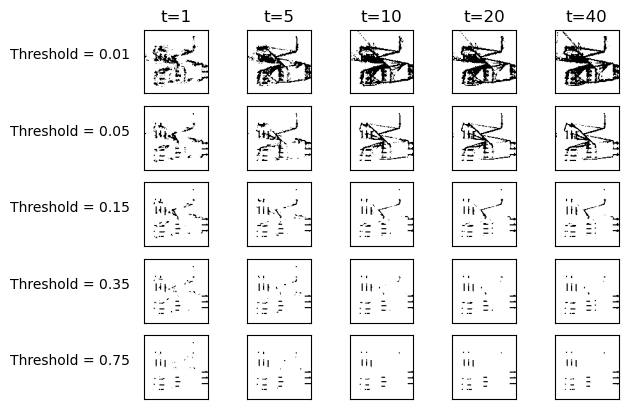

In [29]:
yhat_detached = yhat.cpu().detach().numpy()
yhat_detached = denormalize(mean_features[0], std_features[0], yhat_detached)
grid = CMap2D()

figs, axs = plt.subplots(5, 5)
ts = [1,5,10,20,40]
thresholds = [0.01, 0.05, 0.15, 0.35, 0.75] 

for j, thres in enumerate(thresholds):
    for i,t in enumerate(ts):
        y_hat = back_to_occupancy_grid(yhat_detached, idx, batch_nr=1)    
        y_hat = reshape_output(y_hat, t=t, threshold=thres)
        grid.from_array(y_hat, origin=(0,0), resolution=1.)

        plt.sca(axs[j,i])
        if j==0:
            plt.title("t=" + str(t))
        if i==0:
            plt.ylabel("Threshold = "+ str(thres), rotation=0, labelpad=50)
        plt.xticks(ticks=[])
        plt.yticks(ticks=[])
        gridshow(grid.occupancy())

plt.savefig("figure5x5.png", dpi=3000, bbox_inches = "tight")

### Figure - Heatmaps over time

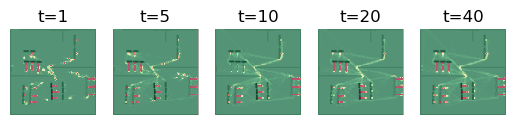

In [30]:
yhat_detached = yhat.cpu().detach().numpy()
yhat_detached = denormalize(mean_features[0], std_features[0], yhat_detached)  
figs, axs = plt.subplots(1, 5)

ts = [1,5,10,20,40]

for j, t in enumerate(ts): 
    y_hat = back_to_occupancy_grid(yhat_detached, idx, batch_nr=1)
    y_hat = np.array(np.array_split(y_hat[:,t-1], 100))
    y_hat = np.rot90(y_hat)
    plt.sca(axs[j])

    ax = sns.heatmap(y_hat, linewidths=0, square=True, cmap='RdYlGn_r', zorder=2, alpha=0.6, cbar=False,vmin=0, vmax=1)
    my_image = mpimg.imread("simu2.png")
    ax.imshow(my_image, aspect=ax.get_aspect(), extent=ax.get_xlim() + ax.get_ylim(), zorder=1)
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    plt.title("t=" + str(t))
        
plt.savefig("figure_heatmap.png", dpi=3000, bbox_inches = "tight")